### Q1: SHO w/ DHO

Generating synthetic datasets...

Fitting models...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 2279.69it/s]



Generating plots...


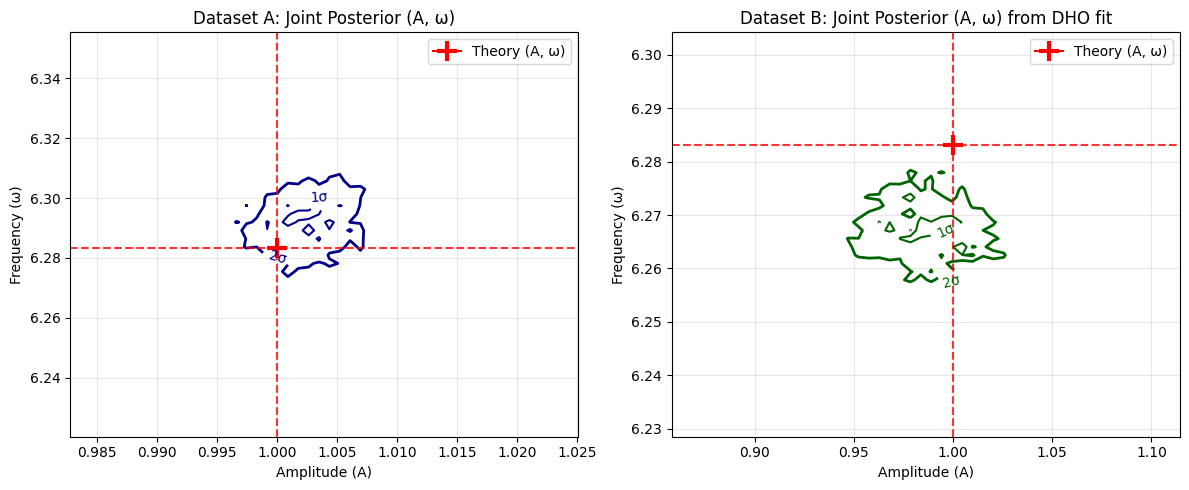

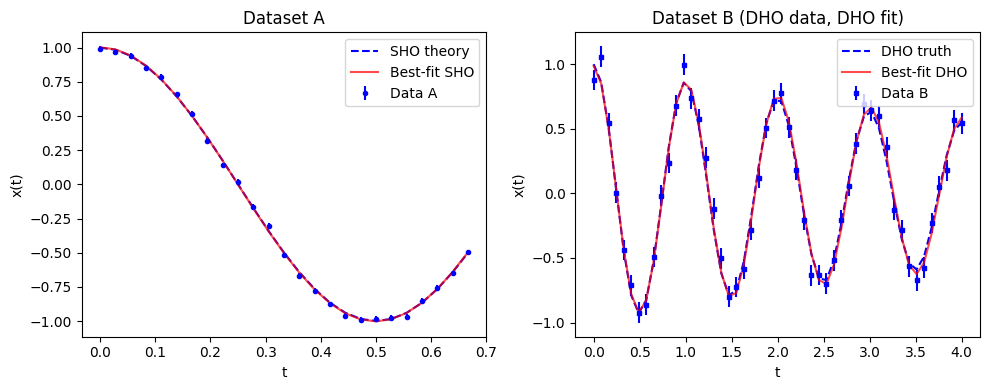

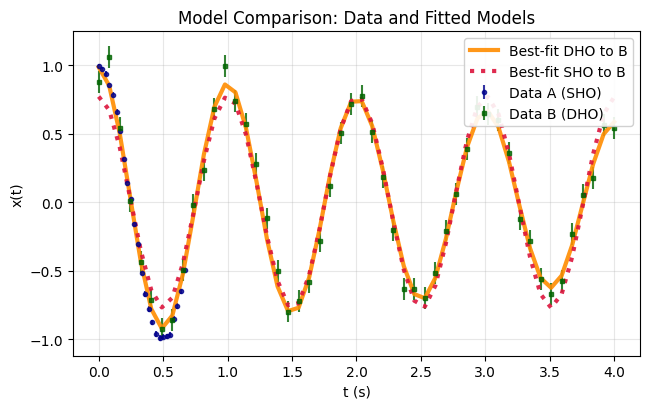

Saved data_comparison to /Users/kahaan/Downloads/cmbagent/evals/discovery/Q1/data_comparison.png

Output directory: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q1


In [4]:
import os
import numpy as np
import emcee
import corner
import shutil
import matplotlib.pyplot as plt

np.random.seed(777)

# Set up output directory
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/evals/discovery/Q1"
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)

# Fixed and true parameters
PHI_FIX = 0.0
C_FIX = 0.0
A_TRUE = 1.0
W_TRUE = 2 * np.pi   # 1 Hz
G_TRUE = 0.15        # damping coefficient

# Noise levels
SIGMA_A = 0.02
SIGMA_B = 0.08

# Time arrays
T_A = np.linspace(0, (2/3) * (2*np.pi / W_TRUE), 25)
T_B = np.linspace(0, 4 * (2*np.pi / W_TRUE), 50)

# Models
def sho(t, A, w, phi=PHI_FIX, c=C_FIX):
    return c + A * np.cos(w*t + phi)

def dho(t, A, w, g, phi=PHI_FIX, c=C_FIX):
    return c + A * np.exp(-g*t) * np.cos(w*t + phi)

# Priors
def log_prior_sho(theta):
    A, w = theta
    if 0 < A < 2 and 0 < w < 20:
        return 0.0
    return -np.inf

def log_prior_dho(theta):
    A, w, g = theta
    if 0 < A < 2 and 0 < w < 20 and 0 < g < 1:
        return 0.0
    return -np.inf

# Likelihoods
def log_likelihood_sho(theta, t, x, sigma):
    A, w = theta
    x_model = sho(t, A, w)
    return -0.5 * np.sum(((x - x_model)/sigma)**2 + np.log(2*np.pi*sigma**2))

def log_likelihood_dho(theta, t, x, sigma):
    A, w, g = theta
    x_model = dho(t, A, w, g)
    return -0.5 * np.sum(((x - x_model)/sigma)**2 + np.log(2*np.pi*sigma**2))

# Posteriors
def log_prob_sho(theta, t, x, sigma):
    lp = log_prior_sho(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_sho(theta, t, x, sigma)

def log_prob_dho(theta, t, x, sigma):
    lp = log_prior_dho(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_dho(theta, t, x, sigma)

# MCMC runners
def run_mcmc_sho(t, x, sigma, nwalkers=40, nsteps=2000, burn=500):
    ndim = 2
    p0 = np.array([A_TRUE, W_TRUE]) + 1e-3 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_sho, args=(t, x, sigma))
    sampler.run_mcmc(p0, nsteps, progress=True)
    return sampler.get_chain(discard=burn, flat=True)

def run_mcmc_dho(t, x, sigma, nwalkers=40, nsteps=2000, burn=500):
    ndim = 3
    p0 = np.array([A_TRUE, W_TRUE, G_TRUE]) + 1e-3 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_dho, args=(t, x, sigma))
    sampler.run_mcmc(p0, nsteps, progress=True)
    return sampler.get_chain(discard=burn, flat=True)

# Generate synthetic datasets
print("Generating synthetic datasets...")
xA_clean = sho(T_A, A_TRUE, W_TRUE)
xA = xA_clean + np.random.normal(0, SIGMA_A, size=T_A.size)
np.savez(os.path.join(OUTPUT_DIR, 'data_A.npz'), t=T_A, x=xA)

xB_clean = dho(T_B, A_TRUE, W_TRUE, G_TRUE)
xB = xB_clean + np.random.normal(0, SIGMA_B, size=T_B.size)
np.savez(os.path.join(OUTPUT_DIR, 'data_B.npz'), t=T_B, x=xB)

# Fit models
print("\nFitting models...")
chain_A_sho = run_mcmc_sho(T_A, xA, SIGMA_A)
chain_B_dho = run_mcmc_dho(T_B, xB, SIGMA_B)
chain_B_sho = run_mcmc_sho(T_B, xB, SIGMA_B)

# Posterior medians and best-fit curves
A_med_A, W_med_A = np.median(chain_A_sho, axis=0)
A_med_B_dho, W_med_B_dho, G_med_B_dho = np.median(chain_B_dho, axis=0)
A_med_B_sho, W_med_B_sho = np.median(chain_B_sho, axis=0)

xA_best = sho(T_A, A_med_A, W_med_A)
xB_best_dho = dho(T_B, A_med_B_dho, W_med_B_dho, G_med_B_dho)
xB_best_sho = sho(T_B, A_med_B_sho, W_med_B_sho)

# Posterior plots
print("\nGenerating plots...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

H, xedges, yedges = np.histogram2d(chain_A_sho[:,0], chain_A_sho[:,1], bins=50, density=True)
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

# Calculate contour levels for 1σ and 2σ (68% and 95%)
sorted_H = np.sort(H.flatten())[::-1]
cum_H = np.cumsum(sorted_H)
cum_H_norm = cum_H / cum_H[-1]
level_68 = sorted_H[np.argmax(cum_H_norm >= 0.32)]  # 1 - 0.68
level_95 = sorted_H[np.argmax(cum_H_norm >= 0.05)]  # 1 - 0.95

contours_A = ax1.contour(x_centers, y_centers, H.T, levels=[level_68, level_95], 
                        colors=['darkblue', 'darkblue'], linewidths=[2, 1.5])
ax1.clabel(contours_A, fmt={level_68: '2σ', level_95: '1σ'}, inline=True, fontsize=10)

# Theory crosshair
ax1.axhline(W_TRUE, color='red', linestyle='--', alpha=0.8, linewidth=1.5)
ax1.axvline(A_TRUE, color='red', linestyle='--', alpha=0.8, linewidth=1.5)
ax1.plot(A_TRUE, W_TRUE, marker='+', markersize=15, color='red', 
         markeredgewidth=3, label='Theory (A, ω)')

ax1.set_xlabel('Amplitude (A)'); ax1.set_ylabel('Frequency (ω)')
ax1.set_title('Dataset A: Joint Posterior (A, ω)')
ax1.legend(); ax1.grid(True, alpha=0.3)

# Joint posterior with contours for Dataset B
H2, xedges2, yedges2 = np.histogram2d(chain_B_dho[:,0], chain_B_dho[:,1], bins=50, density=True)
x_centers2 = 0.5 * (xedges2[1:] + xedges2[:-1])
y_centers2 = 0.5 * (yedges2[1:] + yedges2[:-1])

# Calculate contour levels
sorted_H2 = np.sort(H2.flatten())[::-1]
cum_H2 = np.cumsum(sorted_H2)
cum_H2_norm = cum_H2 / cum_H2[-1]
level_68_2 = sorted_H2[np.argmax(cum_H2_norm >= 0.32)]
level_95_2 = sorted_H2[np.argmax(cum_H2_norm >= 0.05)]

contours_B = ax2.contour(x_centers2, y_centers2, H2.T, levels=[level_68_2, level_95_2], 
                        colors=['darkgreen', 'darkgreen'], linewidths=[2, 1.5])
ax2.clabel(contours_B, fmt={level_68_2: '2σ', level_95_2: '1σ'}, inline=True, fontsize=10)

# Theory crosshair
ax2.axhline(W_TRUE, color='red', linestyle='--', alpha=0.8, linewidth=1.5)
ax2.axvline(A_TRUE, color='red', linestyle='--', alpha=0.8, linewidth=1.5)
ax2.plot(A_TRUE, W_TRUE, marker='+', markersize=15, color='red', 
         markeredgewidth=3, label='Theory (A, ω)')

ax2.set_xlabel('Amplitude (A)'); ax2.set_ylabel('Frequency (ω)')
ax2.set_title('Dataset B: Joint Posterior (A, ω) from DHO fit')
ax2.legend(); ax2.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'posteriors.png'), dpi=160)
plt.show(); plt.close(fig)

# Data vs models plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Dataset A
ax1.errorbar(T_A, xA, yerr=SIGMA_A, fmt='o', ms=3, color='blue', label='Data A')
ax1.plot(T_A, sho(T_A, A_TRUE, W_TRUE), '--', color='blue', label='SHO theory')
ax1.plot(T_A, xA_best, '-', color='red', alpha=0.7, label='Best-fit SHO')
ax1.set_xlabel('t'); ax1.set_ylabel('x(t)'); ax1.set_title('Dataset A')
ax1.legend()

# Dataset B
ax2.errorbar(T_B, xB, yerr=SIGMA_B, fmt='s', ms=3, color='blue', label='Data B')
ax2.plot(T_B, dho(T_B, A_TRUE, W_TRUE, G_TRUE), '--', color='blue', label='DHO truth')
ax2.plot(T_B, xB_best_dho, '-', color='red', alpha=0.7, label='Best-fit DHO')
ax2.set_xlabel('t'); ax2.set_ylabel('x(t)'); ax2.set_title('Dataset B (DHO data, DHO fit)')
ax2.legend()

fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'data_vs_models.png'), dpi=160)
plt.show(); plt.close(fig)

# Overlay comparison plot
fig, ax = plt.subplots(figsize=(6.6, 4.2))

# Dataset A (SHO)
ax.errorbar(T_A, xA, yerr=SIGMA_A, fmt='o', ms=3, color='darkblue', 
           ecolor='darkblue', alpha=0.8, label='Data A (SHO)')

# Dataset B (DHO data) 
ax.errorbar(T_B, xB, yerr=SIGMA_B, fmt='s', ms=2.5, color='darkgreen', 
           ecolor='darkgreen', alpha=0.8, label='Data B (DHO)')

ax.plot(T_B, xB_best_dho, '-', lw=3, alpha=0.9, color='darkorange', 
        label='Best-fit DHO to B')

ax.plot(T_B, xB_best_sho, ':', lw=3, alpha=0.9, color='crimson', 
        label='Best-fit SHO to B')

ax.set_xlabel('t (s)'); ax.set_ylabel('x(t)')
ax.set_title('Model Comparison: Data and Fitted Models')
ax.legend(loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.3)
fig.tight_layout()
fname = os.path.join(OUTPUT_DIR, 'data_comparison.png')
fig.savefig(fname, dpi=160); plt.show()
print(f"Saved data_comparison to {fname}")
plt.close(fig)

print(f"\nOutput directory: {OUTPUT_DIR}")

In [ ]:
import cmbagent

problem_statement = f"""
A new dataset has become available. 
We want to assess whether it provides additional constraints on our null hypothesis,
or whether the null hypothesis should be rejected in favor of an alternative model.
"""

null_hypothesis = f"""
(H0) The observations are described by a simple harmonic oscillator:
$x(t; θ) = A cos(ω t + φ) + c$.
Phase φ = 0 and offset c = 0 are fixed, while amplitude A and frequency ω are free parameters.
"""

prior_context = f"""
With prior data, Dataset A (~2/3 cycle, N=25, σ=0.02), we estimated A ≈ 1.0 and ω ≈ 2π.
Dataset A was consistent with H0.
"""

new_dataset = f"""
Dataset B spans ~4 cycles with N=50 and noise σ=0.08.  
Path: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q1/data_B.npz    
Keys: `t` (time), `x` (observations).
"""

tasks = f"""
Test H0 against Dataset B.
If the free parameters can be effectively constrained, plot their posterior distributions.  
If H0 is rejected, identify and fit an alternative model that better explains Dataset B.
"""

task = f""" 
### Problem Statement
{problem_statement}

### Null Hypothesis (H0)
{null_hypothesis}

### Prior Context (Dataset A)
{prior_context}

### New Dataset
{new_dataset}

### Tasks  
{tasks}
"""


results = cmbagent.one_shot(
    task=task,
    agent='engineer',
    evaluate_plots="discovery",
    clear_work_dir=True
)

### Q2: SHO w/ Chirped Oscillator

In [5]:
import os
import numpy as np
import emcee
import shutil
import matplotlib.pyplot as plt

np.random.seed(777)

# Set up output directory
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/evals/discovery/Q2"
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Fixed settings
PHI_FIX = 0.0
C_FIX = 0.0

# Truth (chirp)
A_TRUE   = 1.0
W0_TRUE  = 2*np.pi     # 1 Hz base
T_TOTAL  = 5*(2*np.pi/W0_TRUE)  # 5 periods
DRIFT_FRAC = 0.20      # end frequency = (1+DRIFT_FRAC) * W0_TRUE
KAPPA_TRUE = (DRIFT_FRAC * W0_TRUE) / T_TOTAL   # ensures linear drift to 1.2*w0 by end

SIGMA = 0.05

# Time grid
T = np.linspace(0, T_TOTAL, 140)

# Models
def sho(t, A, w, phi=PHI_FIX, c=C_FIX):
    return c + A*np.cos(w*t + phi)

def chirp(t, A, w0, kappa, phi=PHI_FIX, c=C_FIX):
    # Instantaneous omega(t) = w0 + kappa t ⇒ phase = w0 t + 0.5 kappa t^2
    return c + A*np.cos(w0*t + 0.5*kappa*(t**2) + phi)

# Generate data (chirp truth)
x_clean = chirp(T, A_TRUE, W0_TRUE, KAPPA_TRUE)
x = x_clean + np.random.normal(0, SIGMA, size=T.size)

np.savez(os.path.join(OUTPUT_DIR, "data_C.npz"), t=T, x=x)

# Log-probabilities for MCMC
def log_prior_sho(theta):
    A, w = theta
    if 0 < A < 2 and 0 < w < 20:
        return 0.0
    return -np.inf

def log_likelihood_sho(theta, t, y, sigma):
    A, w = theta
    yhat = sho(t, A, w)
    return -0.5 * np.sum(((y - yhat)/sigma)**2 + np.log(2*np.pi*sigma**2))

def log_prob_sho(theta, t, y, sigma):
    lp = log_prior_sho(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_sho(theta, t, y, sigma)

def log_prior_chirp(theta):
    A, w0, kappa = theta
    if 0 < A < 2 and 0 < w0 < 20 and -1 < kappa < 1:
        return 0.0
    return -np.inf

def log_likelihood_chirp(theta, t, y, sigma):
    A, w0, kappa = theta
    yhat = chirp(t, A, w0, kappa)
    return -0.5 * np.sum(((y - yhat)/sigma)**2 + np.log(2*np.pi*sigma**2))

def log_prob_chirp(theta, t, y, sigma):
    lp = log_prior_chirp(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_chirp(theta, t, y, sigma)

# MCMC runners
def run_mcmc(fn_logp, p0, nsteps=2000, burn=500):
    import emcee
    nwalkers, ndim = p0.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, fn_logp)
    sampler.run_mcmc(p0, nsteps, progress=True)
    return sampler.get_chain(discard=burn, flat=True)

# SHO fit (misspecified)
p0_sho = np.array([A_TRUE, W0_TRUE]) + 1e-3*np.random.randn(40, 2)
chain_sho = run_mcmc(lambda th: log_prob_sho(th, T, x, SIGMA), p0_sho)

# Chirp fit (correct)
p0_chirp = np.array([A_TRUE, W0_TRUE, KAPPA_TRUE]) + 1e-3*np.random.randn(50, 3)
chain_chirp = run_mcmc(lambda th: log_prob_chirp(th, T, x, SIGMA), p0_chirp)

# Posterior medians & best-fits
A_med_sho, W_med_sho = np.median(chain_sho, axis=0)
A_med_ch, W0_med_ch, KAP_med_ch = np.median(chain_chirp, axis=0)

x_best_sho   = sho(T,  A_med_sho, W_med_sho)
x_best_chirp = chirp(T, A_med_ch, W0_med_ch, KAP_med_ch)

# Plots
# 1) Data vs fits
fig, ax = plt.subplots(figsize=(7.2, 4.2))
ax.errorbar(T, x, yerr=SIGMA, fmt='.', ms=3, alpha=0.8, label='Data')
ax.plot(T, x_best_sho,   ':',  lw=2.5, alpha=0.9, label='Best-fit SHO')
ax.plot(T, x_best_chirp, '-',  lw=2.5, alpha=0.9, label='Best-fit Chirp')
ax.plot(T, x_clean,      '--', lw=1.2, alpha=0.7, label='Truth (Chirp)')
ax.set_xlabel('t (s)'); ax.set_ylabel('x(t)'); ax.set_title('SHO vs Chirp')
ax.legend(); ax.grid(alpha=0.3); fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "overlay_sho_vs_chirp.png"), dpi=160)
plt.close(fig)

# 2) Residuals: SHO shows phase-drift structure; Chirp ~ noise
resid_sho   = x - x_best_sho
resid_chirp = x - x_best_chirp

fig, ax = plt.subplots(figsize=(7.2, 3.8))
ax.plot(T, resid_sho,   '.', ms=3, label='Residuals (SHO)')
ax.plot(T, resid_chirp, '.', ms=2, alpha=0.7, label='Residuals (Chirp)')
ax.axhline(0, lw=1, alpha=0.6)
ax.fill_between(T, -SIGMA, SIGMA, alpha=0.2, label='±1σ noise')
ax.set_xlabel('t (s)'); ax.set_ylabel('Residual'); ax.set_title('Residuals')
ax.legend(); ax.grid(alpha=0.3); fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "residuals_compare.png"), dpi=160)
plt.close(fig)

# 3) Joint posteriors (A, ω) for SHO; (ω0, κ) for Chirp
def contour_levels(H, probs=(0.95, 0.68)):
    s = np.sort(H.ravel())[::-1]
    c = np.cumsum(s)/np.sum(s)
    levels = []
    for p in probs:
        thr = s[np.searchsorted(c, p)]
        levels.append(thr)
    return levels

# SHO: (A, w)
H1, xe1, ye1 = np.histogram2d(chain_sho[:,0], chain_sho[:,1], bins=50, density=True)
x1c = 0.5*(xe1[1:]+xe1[:-1]); y1c = 0.5*(ye1[1:]+ye1[:-1])
lev1, lev2 = contour_levels(H1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4.6))
cs1 = ax1.contour(x1c, y1c, H1.T, levels=[lev1, lev2])
ax1.axvline(A_TRUE, ls='--'); ax1.axhline(W0_TRUE, ls='--')
ax1.plot(A_TRUE, W0_TRUE, '+', ms=12)
ax1.set_xlabel('A'); ax1.set_ylabel('ω'); ax1.set_title('SHO: Joint Posterior (A, ω)')

# Chirp: (ω0, κ)
H2, xe2, ye2 = np.histogram2d(chain_chirp[:,1], chain_chirp[:,2], bins=50, density=True)
x2c = 0.5*(xe2[1:]+xe2[:-1]); y2c = 0.5*(ye2[1:]+ye2[:-1])
lev1b, lev2b = contour_levels(H2)
cs2 = ax2.contour(x2c, y2c, H2.T, levels=[lev1b, lev2b])
ax2.axvline(W0_TRUE, ls='--'); ax2.axhline(KAPPA_TRUE, ls='--')
ax2.plot(W0_TRUE, KAPPA_TRUE, '+', ms=12)
ax2.set_xlabel('ω₀'); ax2.set_ylabel('κ'); ax2.set_title('Chirp: Joint Posterior (ω₀, κ)')

fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "posteriors.png"), dpi=160)
plt.close(fig)

# Results summary
print("\n=== RESULTS ===")
print(f"Truth: A={A_TRUE:.3f}, w0={W0_TRUE:.3f}, kappa={KAPPA_TRUE:.5f}")
print(f"SHO median:   A={A_med_sho:.3f}, w={W_med_sho:.3f}")
print(f"Chirp median: A={A_med_ch:.3f}, w0={W0_med_ch:.3f}, kappa={KAP_med_ch:.5f}")
print(f"RMSE(SHO)   = {np.sqrt(np.mean(resid_sho**2)):.4f}")
print(f"RMSE(Chirp) = {np.sqrt(np.mean(resid_chirp**2)):.4f}")
print(f"Data saved to: {OUTPUT_DIR}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1603.70it/s]



=== RESULTS ===
Truth: A=1.000, w0=6.283, kappa=0.25133
SHO median:   A=0.939, w=6.758
Chirp median: A=0.997, w0=6.263, kappa=0.26095
RMSE(SHO)   = 0.2594
RMSE(Chirp) = 0.0455
Data saved to: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q2


In [ ]:
import cmbagent

problem_statement = """
A new dataset has become available. 
We want to assess whether it provides additional constraints on our null hypothesis,
or whether the null hypothesis should be rejected in favor of an alternative model.
"""

null_hypothesis = r"""
(H0) The observations are described by a simple harmonic oscillator:
$x(t; θ) = A cos(ω t + φ) + c$.
Phase φ = 0 and offset c = 0 are fixed, while amplitude A and frequency ω are free parameters.
"""

prior_context = """
Earlier short-interval datasets were consistent with H0.
"""

new_dataset = """
Path: /Users/kahaan/Downloads/cmbagent/evals/discovery/data_C.npz
Keys: 't' (time), 'x' (observations).
"""

tasks = """
Test H0 against the new dataset and plot the result.
If H0 is rejected, identify and fit an alternative model that better explains the data.
"""

task = f"""
### Problem Statement
{problem_statement}

### Null Hypothesis (H0)
{null_hypothesis}

### Prior Context
{prior_context}

### New Dataset
{new_dataset}

### Tasks
{tasks}
"""

results = cmbagent.one_shot(
    task=task,
    agent="engineer",
    evaluate_plots="discovery",
    clear_work_dir=True
)

### Q3: Astrochem w/ Double Gaussians

In [6]:
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(777)

# Paths
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/evals/discovery/Q3"

# Clean slate
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Blend generator: subtle-to-obvious
OBVIOUSNESS = 0.40  # tweak [0, 1]

# Axis
N = 400
v = np.linspace(-6.0, 6.0, N)          # velocity (km/s)

# True parameters
mu0 = 0.0
sigma_true = 1.0

delta_v = (0.8 + 1.2 * OBVIOUSNESS) * sigma_true
amp_ratio = 0.6 + 0.4 * OBVIOUSNESS

mu1, mu2 = mu0 - 0.5*delta_v, mu0 + 0.5*delta_v
A1, A2 = 1.0, amp_ratio
c0 = 0.0

def gauss(v, mu, sig, amp):
    return amp * np.exp(-0.5 * ((v - mu)/sig)**2)

# True signal (double Gaussian)
I_true_double = c0 + gauss(v, mu1, sigma_true, A1) + gauss(v, mu2, sigma_true, A2)

# Noise
sigma_n = 0.01 * np.max(I_true_double)
I = I_true_double + np.random.normal(0.0, sigma_n, size=v.size)

# Single-Gaussian
edge_frac = 0.15
k = int(edge_frac * N)
off_mask = np.zeros_like(v, dtype=bool)
off_mask[:k] = True
off_mask[-k:] = True
c0_est = np.median(I[off_mask])

y = np.clip(I - c0_est, a_min=0.0, a_max=None)
weight = y + 1e-12
mu_est = np.sum(v * weight) / np.sum(weight)
var_est = np.sum(weight * (v - mu_est)**2) / np.sum(weight)
sigma_est = np.sqrt(max(var_est, (0.3)**2))
A_est = np.max(y)

I_single = c0_est + gauss(v, mu_est, sigma_est, A_est)

# Residuals
resid_single = I - I_single
resid_double = I - I_true_double

# # Save dataset
# meta = {
#     "description": "Double-Gaussian blend; only misspecification is treating as single Gaussian.",
#     "obviousness": float(OBVIOUSNESS),
#     "true_params": {
#         "mu1": float(mu1), "mu2": float(mu2),
#         "sigma": float(sigma_true), "A1": float(A1), "A2": float(A2),
#         "delta_v": float(delta_v), "amp_ratio": float(amp_ratio)
#     },
#     "noise_sigma": float(sigma_n),
#     "line_window": [-3.0, 3.0],
#     "off_window_fraction_per_side": edge_frac
# }

np.savez(
    os.path.join(OUTPUT_DIR, "dataset.npz"),
    v=v,
    I=I,
    sigma=np.full_like(v, sigma_n),
    # meta=json.dumps(meta),
)

# Plots
# 1) Data + single-Gaussian fit
fig, ax = plt.subplots(figsize=(7.2, 4.2))
ax.plot(v, I, ".", ms=3, alpha=0.9, label="Data")
ax.plot(v, I_single, "-", lw=2, label="Single-Gaussian fit")
ax.set_xlabel("v (km/s)")
ax.set_ylabel("Intensity")
ax.set_title(f"Blend (obviousness={OBVIOUSNESS:.2f}): Single-Gaussian Fit")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "overlay_single_gauss.png"), dpi=160)
plt.close(fig)

# 2) Residuals for single vs double Gaussian
fig, ax = plt.subplots(figsize=(7.2, 3.8))
ax.plot(v, resid_single, ".", ms=3, label="Residuals (single-Gauss)")
ax.plot(v, resid_double, ".", ms=2, alpha=0.6, label="Residuals (double-Gauss)")
ax.axhline(0, lw=1, color="k", alpha=0.6)
ax.fill_between(v, -sigma_n, sigma_n, color="gray", alpha=0.2, label="±1σ noise")
ax.set_xlabel("v (km/s)")
ax.set_ylabel("Residual")
ax.set_title("Residuals: Single vs Double Gaussian")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "residuals_compare.png"), dpi=160)
plt.close(fig)

# 3) Data + double Gaussian fit (true components)
fig, ax = plt.subplots(figsize=(7.2, 4.2))
ax.plot(v, I, ".", ms=3, alpha=0.5, label="Data")
ax.plot(v, I_true_double, "-", lw=2, alpha=0.9, label="True double-Gaussian sum")
ax.plot(v, gauss(v, mu1, sigma_true, A1), "--", lw=1.5, label="Component 1")
ax.plot(v, gauss(v, mu2, sigma_true, A2), "--", lw=1.5, label="Component 2")
ax.set_xlabel("v (km/s)")
ax.set_ylabel("Intensity")
ax.set_title("Ground Truth: Double-Gaussian Fit")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "overlay_double_gauss.png"), dpi=160)
plt.close(fig)

print("Saved to", OUTPUT_DIR)

Saved to /Users/kahaan/Downloads/cmbagent/evals/discovery/Q3


In [ ]:
import cmbagent

problem_statement = f"""
A new dataset has become available. 
We want to assess whether it provides additional constraints on our null hypothesis,
or whether the null hypothesis should be rejected in favor of an alternative model.
"""

null_hypothesis = f"""
(H₀) The spectral line profile is described by a single Gaussian component on top of a constant continuum baseline, with independent Gaussian channel noise:
$I(v;θ) = c₀ + A  exp[-(v - μ)^2 / (2σ^2)]$.
"""

prior_context = f"""
Similar spectral features in prior datasets were well-described by H₀.
"""

new_dataset = f"""
Path: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q3/dataset.npz  
Keys: "v" (velocity axis), "I" (intensity), "sigma" (per-channel noise).
"""

tasks = f"""
Test H₀ against the new dataset.  
Plot the residuals, and if H0 is rejected, identify and fit an alternative line-profile model that better explains the data.
"""

task = f"""
### Problem Statement
{problem_statement}

### Null Hypothesis (H₀)
{null_hypothesis}

### Prior Context
{prior_context}

### New Dataset
{new_dataset}

### Tasks
{tasks}
"""

results = cmbagent.one_shot(
    task=task,
    agent='engineer',
    evaluate_plots="discovery",
    clear_work_dir=True
)

### Q4: Astrochem w/ Self-Absorption

In [9]:
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(777)

# Paths
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/evals/discovery/Q5"

# Clean slate
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPATH = os.path.join(OUTPUT_DIR, "dataset.npz")

OBVIOUSNESS = 0.30
N = 500
v = np.linspace(-6.0, 6.0, N)  # km/s

# Emission parameters
mu0 = 0.0
sigma_em = 1.0
A_em = 1.0
c0 = 0.0

# Absorption parameters
sigma_abs = 0.35
depth = 0.15 + 0.55 * OBVIOUSNESS
mu_abs = mu0
A_abs = -depth * A_em

def gauss(v, mu, sig, amp):
    return amp * np.exp(-0.5 * ((v - mu)/sig)**2)

# True signal
I_true = (
    c0
    + gauss(v, mu0, sigma_em, A_em)
    + gauss(v, mu_abs, sigma_abs, A_abs)
)

# Noise
sigma_n = 0.012 * np.max(np.abs(I_true))
I = I_true + np.random.normal(0.0, sigma_n, size=v.size)

# Null fit: single-Gaussian
edge_frac = 0.18
k = int(edge_frac * N)
off_mask = np.zeros_like(v, dtype=bool)
off_mask[:k] = True
off_mask[-k:] = True
c0_est = np.median(I[off_mask])

y = np.clip(I - c0_est, a_min=0.0, a_max=None)
w = y + 1e-12
mu_est = np.sum(v * w) / np.sum(w)
var_est = np.sum(w * (v - mu_est)**2) / np.sum(w)
sigma_est = np.sqrt(max(var_est, 0.25**2))
A_est = np.max(y)

I_single = c0_est + gauss(v, mu_est, sigma_est, A_est)

# Alternative (illustration only)
I_two_layer = (
    c0_est
    + gauss(v, mu0, sigma_em, A_em)
    + gauss(v, mu_abs, sigma_abs, A_abs)
)

# Residuals
resid_single = I - I_single
resid_two = I - I_two_layer

# Diagnostics
def moment1_centroid(vax, flux):
    flux_pos = np.clip(
        flux - np.median(flux[:k].tolist() + flux[-k:].tolist()),
        0.0,
        None,
    )
    m0 = np.sum(flux_pos)
    if m0 <= 0:
        return float("nan")
    return float(np.sum(vax * flux_pos) / m0)

diag = {
    "mu_true": float(mu0),
    "centroid_data": moment1_centroid(v, I),
    "centroid_null_model": float(mu_est),
    "sigma_noise": float(sigma_n),
    "absorption_depth_fraction": float(depth),
}

np.savez(
    os.path.join(OUTPUT_DIR, "dataset.npz"),
    v=v,
    I=I,
    sigma=np.full_like(v, sigma_n),
)

# Plots
# Data + single-Gaussian fit
fig, ax = plt.subplots(figsize=(7.2, 4.2))
ax.plot(v, I, ".", ms=3, alpha=0.9, label="Data")
ax.plot(v, I_single, "-", lw=2, label="Single-Gaussian fit (H0)")
ax.set_xlabel("v (km/s)")
ax.set_ylabel("Intensity")
ax.set_title(f"Self-Absorption (obviousness={OBVIOUSNESS:.2f}): Null Fit")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "overlay_single_gauss.png"), dpi=160)
plt.close(fig)

# Residuals: null vs alt
fig, ax = plt.subplots(figsize=(7.2, 3.8))
ax.plot(v, resid_single, ".", ms=3, label="Residuals (single-Gauss)")
ax.plot(v, resid_two, ".", ms=2, alpha=0.6, label="Residuals (self-abs alt)")
ax.axhline(0, lw=1, color="k", alpha=0.6)
ax.fill_between(v, -sigma_n, sigma_n, color="gray", alpha=0.2, label="±1σ noise")
ax.set_xlabel("v (km/s)")
ax.set_ylabel("Residual")
ax.set_title("Residuals: Null vs Proposed")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "residuals_compare.png"), dpi=160)
plt.close(fig)

# Data + alt with components
fig, ax = plt.subplots(figsize=(7.2, 4.2))
ax.plot(v, I, ".", ms=3, alpha=0.6, label="Data")
ax.plot(v, I_two_layer, "-", lw=2, alpha=0.9, label="Self-absorption (alt)")
ax.plot(v, gauss(v, mu0, sigma_em, A_em), "--", lw=1.5, label="Emission")
ax.plot(v, gauss(v, mu_abs, sigma_abs, A_abs), "--", lw=1.5, label="Absorption")
ax.set_xlabel("v (km/s)")
ax.set_ylabel("Intensity")
ax.set_title("Ground Truth: Emission − Absorption")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "overlay_self_absorption.png"), dpi=160)
plt.close(fig)

with open(os.path.join(OUTPUT_DIR, "diagnostics.json"), "w") as f:
    json.dump(diag, f, indent=2)

print("Saved to", OUTPUT_DIR)
print(diag)

Saved to /Users/kahaan/Downloads/cmbagent/evals/discovery/Q5
{'mu_true': 0.0, 'centroid_data': -0.0019158645328262872, 'centroid_null_model': -0.0019158645328160623, 'sigma_noise': 0.009229150887194452, 'absorption_depth_fraction': 0.315}


In [ ]:
import cmbagent

problem_statement = f"""
A new dataset has become available.
We want to assess whether it provides additional constraints on our null hypothesis,
or whether the null hypothesis should be rejected in favor of an alternative model.
"""

null_hypothesis = f"""
(H₀) The spectral line profile is a single Gaussian on a constant continuum with independent Gaussian channel noise:
I(v; θ) = c₀ + A * exp(-(v - μ)^2 / (2σ^2)).
The centroid parameter μ of this Gaussian has the systemic velocity μ ≈ 0.
"""

prior_context = f"""
Prior sources showed approximately Gaussian profiles consistent with H₀.
"""

new_dataset = f"""
Path: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q5/dataset.npz
Keys: "v" (velocity axis), "I" (intensity), "sigma" (per-channel noise).
"""

tasks = f"""
Test H₀ against the new dataset. 
Plot the residuals, and if H0 is rejected, identify and fit an alternative line-profile model that better explains the data.
"""

task = f"""
### Problem Statement
{problem_statement}

### Null Hypothesis (H₀)
{null_hypothesis}

### Prior Context
{prior_context}

### New Dataset
{new_dataset}

### Tasks
{tasks}
"""

results = cmbagent.one_shot(
    task=task,
    agent='engineer',
    evaluate_plots="discovery",
    clear_work_dir=True
)

### Q5: Astrochem w/ Hyperfine Structure

In [ ]:
# HCN(1-0) hyperfine episode: truth is 3-component HFS; H0 is single Gaussian
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(777)

# Paths
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/evals/discovery/Q5"

# Clean slate
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Controls
N = 600
v = np.linspace(-12.0, 12.0, N)     # km/s
sigma_n = 0.010
OBVIOUSNESS = 0.35
mu_sys = 0.0
sigma_shared = 1.0
A_total = 1.0
c0 = 0.0

# HCN(1-0) triplet: F=0-1, 2-1, 1-1
base_offsets = np.array([-7.1, 0.0, +4.8])
base_weights = np.array([1.0, 5.0, 3.0], dtype=float)
base_weights /= base_weights.sum()

sep_scale = 1.0 + 0.8 * (OBVIOUSNESS - 0.5)
offsets = mu_sys + sep_scale * base_offsets
weights = base_weights

def gauss(v, mu, sig, amp):
    return amp * np.exp(-0.5 * ((v - mu) / sig) ** 2)

# Truth: HFS sum
I_true = (
    c0
    + np.sum(
        [gauss(v, mu_i, sigma_shared, A_total * w_i) for mu_i, w_i in zip(offsets, weights)],
        axis=0,
    )
)

# Add noise
I = I_true + np.random.normal(0.0, sigma_n, size=v.size)

# Null fit: single Gaussian
edge_frac = 0.20
k = int(edge_frac * N)
off_mask = np.zeros_like(v, dtype=bool)
off_mask[:k] = True
off_mask[-k:] = True
c0_est = np.median(I[off_mask])

y = np.clip(I - c0_est, a_min=0.0, a_max=None)
w = y + 1e-12
mu_est = np.sum(v * w) / np.sum(w)
var_est = np.sum(w * (v - mu_est) ** 2) / np.sum(w)
sigma_est = np.sqrt(max(var_est, 0.35 ** 2))
A_est = np.max(y)

I_single = c0_est + gauss(v, mu_est, sigma_est, A_est)

# For inspection: HFS model with known offsets and strengths
I_hfs_model = (
    c0_est
    + np.sum(
        [gauss(v, mu_i, sigma_shared, A_est * (w_i / weights.max())) for mu_i, w_i in zip(offsets, weights)],
        axis=0,
    )
)

# Residuals
resid_single = I - I_single
resid_hfs = I - I_hfs_model

# Save dataset
np.savez(
    OUTPATH,
    v=v,
    I=I,
    sigma=np.full_like(v, sigma_n),
)

print("Saved dataset to:", OUTPUT_DIR)

# Plots
# Data + single-Gaussian fit
fig, ax = plt.subplots(figsize=(7.2, 4.2))
ax.plot(v, I, ".", ms=3, alpha=0.9, label="Data")
ax.plot(v, I_single, "-", lw=2, label="Single-Gaussian fit (H0)")
ax.set_xlabel("v (km/s)")
ax.set_ylabel("Intensity")
ax.set_title(f"HCN(1-0) HFS mimicking a Gaussian (obviousness={OBVIOUSNESS:.2f})")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "overlay_single_gaussian.png"), dpi=160)
plt.close(fig)

# Residuals: null vs HFS
fig, ax = plt.subplots(figsize=(7.2, 3.8))
ax.plot(v, resid_single, ".", ms=3, label="Residuals (H0)")
ax.plot(v, resid_hfs, ".", ms=2, alpha=0.6, label="Residuals (HFS alt)")
ax.axhline(0, lw=1, alpha=0.6)
ax.fill_between(v, -sigma_n, sigma_n, alpha=0.2, label="±1σ noise")
ax.set_xlabel("v (km/s)")
ax.set_ylabel("Residual")
ax.set_title("Residuals: single Gaussian vs HFS")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "residuals_compare.png"), dpi=160)
plt.close(fig)

# Data + HFS ground truth
fig, ax = plt.subplots(figsize=(7.2, 4.2))
ax.plot(v, I, ".", ms=3, alpha=0.6, label="Data")
ax.plot(v, I_true, "-", lw=2, alpha=0.9, label="Ground truth: HCN HFS sum")
for mu_i, w_i in zip(offsets, weights):
    ax.plot(v, gauss(v, mu_i, sigma_shared, A_total * w_i), "--", lw=1.2)
ax.set_xlabel("v (km/s)")
ax.set_ylabel("Intensity")
ax.set_title("HCN(1-0): hyperfine components")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "overlay_hfs_truth.png"), dpi=160)
plt.close(fig)

In [ ]:
import cmbagent

problem_statement = f"""
A new dataset has become available.
We want to assess whether it provides additional constraints on our null hypothesis,
or whether the null hypothesis should be rejected in favor of an alternative model.
"""

null_hypothesis = f"""
(H0) The spectral line profile is a single Gaussian on a constant continuum with independent Gaussian channel noise:
I(v; θ) = c0 + A * exp(-(v - μ)^2 / (2σ^2)).
"""

prior_context = f"""
Prior lines appeared approximately Gaussian and consistent with H0.
"""

new_dataset = f"""
Path: /Users/kahaan/Downloads/cmbagent/LineProfiles/Q2/Lines_Q2.npz
Keys: "v" (velocity axis), "I" (intensity), "sigma" (per-channel noise).
"""

tasks = f"""
Test H0 against the new dataset.
Plot the residuals, and if H0 is rejected, identify and fit an alternative line-profile model that better explains the data.
"""

task = f"""
### Problem Statement
{problem_statement}

### Null Hypothesis (H0)
{null_hypothesis}

### Prior Context
{prior_context}

### New Dataset
{new_dataset}

### Tasks
{tasks}
"""

results = cmbagent.one_shot(
    task=task,
    agent='engineer',
    evaluate_plots="discovery",
    clear_work_dir=True
)

### Q6: SEIR w/ Waning Immunity

In [10]:
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(777)

# Paths
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/evals/discovery/Q6"

# Clean slate
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPATH = os.path.join(OUTPUT_DIR, "dataset.npz")

# RK4 integrator
def rk4_step(f, y, t, dt):
    k1 = f(y, t)
    k2 = f(y + 0.5 * dt * k1, t + 0.5 * dt)
    k3 = f(y + 0.5 * dt * k2, t + 0.5 * dt)
    k4 = f(y + dt * k3, t + dt)
    return y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# SEIRS simulator
def simulate(T, dt, params, y0, with_waning=True, with_season=True):
    beta0 = params["beta0"]
    a = params["amp"]
    P = params["P"]
    phi = params["phi"]
    sigma = params["sigma"]
    gamma = params["gamma"]
    xi = params["xi"] if with_waning else 0.0

    def beta_t(tt):
        if with_season:
            return beta0 * (1.0 + a * np.cos(2 * np.pi * (tt - phi) / P))
        else:
            return beta0

    def f(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        b = beta_t(tt)
        dS = -b * S * I / N + xi * R
        dE = b * S * I / N - sigma * E
        dI = sigma * E - gamma * I
        dR = gamma * I - xi * R
        return np.array([dS, dE, dI, dR])

    steps = int(T / dt) + 1
    tgrid = np.linspace(0, T, steps)
    Y = np.zeros((steps, 4))
    Y[0] = y0
    for i in range(steps - 1):
        Y[i + 1] = rk4_step(f, Y[i], tgrid[i], dt)
    return tgrid, Y

# Settings
T_days = 365
dt = 1.0
sigma = 1 / 4.0
gamma = 1 / 7.0

# Truth parameters
truth = {
    "beta0": 0.435,
    "amp": 0.14,
    "P": 330.0,
    "phi": 180.0,
    "sigma": sigma,
    "gamma": gamma,
    "xi": 1 / 400.0,
}

# Initial conditions
I0, E0, R0 = 0.0040, 0.0020, 0.0
S0 = 1.0 - I0 - E0 - R0
y0 = np.array([S0, E0, I0, R0])

# Simulations
t, Y_true = simulate(T_days, dt, truth, y0, with_waning=True, with_season=True)
I_true = Y_true[:, 2]

noise_frac = 0.02
noise_sigma = noise_frac * max(np.max(I_true), 1e-6)
I_obs = np.clip(I_true + np.random.normal(0.0, noise_sigma, size=I_true.size), 0.0, None)

beta_const = truth["beta0"]
null = {
    "beta0": beta_const,
    "amp": 0.0,
    "P": truth["P"],
    "phi": truth["phi"],
    "sigma": sigma,
    "gamma": gamma,
    "xi": 0.0,
}

t_null, Y_null = simulate(T_days, dt, null, y0, with_waning=False, with_season=False)
I_null = Y_null[:, 2]

t_fix, Y_fix = simulate(T_days, dt, truth, y0, with_waning=True, with_season=True)
I_fix = Y_fix[:, 2]

resid_null = I_obs - I_null
resid_fix = I_obs - I_fix

# Save dataset
np.savez(
    OUTPATH,
    t=t,
    I=I_obs,
    sigma=np.full_like(t, noise_sigma, dtype=float),
)

# Plots
# Data vs null SEIR
plt.figure(figsize=(7.2, 4.2))
plt.plot(t, I_obs, ".", ms=3, alpha=0.8, label="Data (I_obs)")
plt.plot(t, I_null, "-", lw=2, label="Null SEIR fit (no waning)")
plt.xlabel("t (days)")
plt.ylabel("Active infections (fraction)")
plt.title("Near-Look-Alike: Data vs Null SEIR")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "overlay_seir_null.png"), dpi=160)
plt.close()

# Residuals
plt.figure(figsize=(7.2, 3.8))
plt.plot(t, resid_null, ".", ms=3, label="Residuals (SEIR null)")
plt.plot(t, resid_fix, ".", ms=2, alpha=0.6, label="Residuals (SEIRS alt)")
plt.axhline(0, lw=1, alpha=0.6)
plt.fill_between(t, -noise_sigma, noise_sigma, alpha=0.2, label="±1σ noise")
plt.xlabel("t (days)")
plt.ylabel("Residual")
plt.title("Residuals: Null vs Proposed")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "residuals_compare.png"), dpi=160)
plt.close()

# Alt SEIRS
plt.figure(figsize=(7.2, 4.2))
plt.plot(t, I_obs, ".", ms=3, alpha=0.5, label="Data (I_obs)")
plt.plot(t, I_fix, "-", lw=2, alpha=0.9, label="SEIRS (waning + seasonality)")
plt.xlabel("t (days)")
plt.ylabel("Active infections (fraction)")
plt.title("Proposed SEIRS Captures Shoulder/Tail")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "overlay_seirs_alt.png"), dpi=160)
plt.close()

# Diagnostics
diag = {
    "mse_null": float(np.mean((I_obs - I_null) ** 2)),
    "mse_seirs": float(np.mean((I_obs - I_fix) ** 2)),
    "peak_day_obs": float(t[np.argmax(I_obs)]),
    "peak_day_null": float(t[np.argmax(I_null)]),
    "peak_day_seirs": float(t[np.argmax(I_fix)]),
}

with open(os.path.join(OUTPUT_DIR, "diagnostics.json"), "w") as f:
    json.dump(diag, f, indent=2)

print("Saved to", OUTPUT_DIR)
print(diag)

Saved to /Users/kahaan/Downloads/cmbagent/evals/discovery/Q6
{'mse_null': 0.00025639129168762595, 'mse_seirs': 7.756337600869188e-06, 'peak_day_obs': 50.0, 'peak_day_null': 42.0, 'peak_day_seirs': 48.0}


In [ ]:
import cmbagent

problem_statement = f"""
A new dataset has become available. 
We want to assess whether it provides additional constraints on our null hypothesis,
or whether the null hypothesis should be rejected in favor of an alternative model.
"""

null_hypothesis = f"""
(H₀) The outbreak dynamics follow a standard SEIR model for active infections I(t) under homogeneous mixing and constant parameters.

Model:
  dS/dt = -β S I
  dE/dt =  β S I - σ E
  dI/dt =  σ E - γ I
  dR/dt =  γ I
"""

prior_context = f"""
Earlier datasets were roughly single-wave and appeared consistent with H0.
"""

new_dataset = f"""
Path: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q6/dataset.npz
Keys: "t" (days), "I" (observed active infections), "sigma" (per-timepoint noise).
"""

tasks = f"""
Test H0 against the new dataset.
Plot the residuals, and if H0 is rejected, identify and fit an alternative epidemiological model that better explains the data.
"""

task = f"""
### Problem Statement
{problem_statement}

### Null Hypothesis (H₀)
{null_hypothesis}

### Prior Context
{prior_context}

### New Dataset
{new_dataset}

### Tasks
{tasks}
"""

results = cmbagent.one_shot(
    task=task,
    agent="engineer",
    evaluate_plots="discovery",
    clear_work_dir=True
)

### Q7: SEIR w/ Behavior Feedback

In [12]:
import os
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(777)

# Paths
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/evals/discovery/Q7"

# Clean slate
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPATH = os.path.join(OUTPUT_DIR, "dataset.npz")

# Integrator (RK4)
def rk4_step(f, y, t, dt):
    k1 = f(y, t)
    k2 = f(y + 0.5 * dt * k1, t + 0.5 * dt)
    k3 = f(y + 0.5 * dt * k2, t + 0.5 * dt)
    k4 = f(y + dt * k3, t + dt)
    return y + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# Simulator
def simulate(T, dt, params, y0, with_behavior=False, p=1.0):
    """
    SEIR with optional behavioral feedback:
      dS = -β_eff S I
      dE =  β_eff S I - σ E
      dI =  σ E - γ I
      dR =  γ I

    β_eff = β0 / (1 + k * I^p)   if with_behavior else β0
    """
    beta0 = params["beta0"]
    sigma = params["sigma"]
    gamma = params["gamma"]
    k = params.get("k", 0.0)

    def beta_eff(I):
        if with_behavior:
            return beta0 / (1.0 + k * (I ** p))
        else:
            return beta0

    def f(y, tt):
        S, E, I, R = y
        N = S + E + I + R
        b = beta_eff(I)
        dS = -b * S * I / N
        dE = b * S * I / N - sigma * E
        dI = sigma * E - gamma * I
        dR = gamma * I
        return np.array([dS, dE, dI, dR])

    steps = int(T / dt) + 1
    tgrid = np.linspace(0, T, steps)
    Y = np.zeros((steps, 4))
    Y[0] = y0
    for i in range(steps - 1):
        Y[i + 1] = rk4_step(f, Y[i], tgrid[i], dt)
    return tgrid, Y

def mse(a, b):
    return float(np.mean((a - b) ** 2))

# Parameters
T_days = 365
dt = 1.0
sigma = 1 / 4.0  # E -> I rate
gamma = 1 / 7.0  # I -> R rate

# Base transmissibility (R0 ≈ beta0/gamma with S≈1)
beta0 = 0.42

# Behavioral feedback strength (truth)
k_behavior = 1.0
p_behavior = 1.0

# Initial conditions (normalized population)
I0, E0, R0 = 0.004, 0.002, 0.0
S0 = 1.0 - I0 - E0 - R0
y0 = np.array([S0, E0, I0, R0])

truth = {
    "beta0": beta0,
    "sigma": sigma,
    "gamma": gamma,
    "k": k_behavior,
    "p": p_behavior,
}

null = {
    "beta0": beta0,
    "sigma": sigma,
    "gamma": gamma,
    "k": 0.0,   # no behavior in H0
    "p": 1.0,
}

# Simulate data (truth: behavior feedback) + null fit (constant beta)
t, Y_true = simulate(T_days, dt, truth, y0, with_behavior=True, p=p_behavior)
I_true = Y_true[:, 2]

# Observation noise
noise_frac = 0.02
noise_sigma = noise_frac * max(np.max(I_true), 1e-6)
I_obs = np.clip(I_true + np.random.normal(0.0, noise_sigma, size=I_true.size), 0.0, None)

t_null, Y_null = simulate(T_days, dt, null, y0, with_behavior=False)
I_null = Y_null[:, 2]

t_alt, Y_alt = simulate(T_days, dt, truth, y0, with_behavior=True, p=p_behavior)
I_alt = Y_alt[:, 2]

# Residuals
resid_null = I_obs - I_null
resid_alt = I_obs - I_alt

# Save dataset
np.savez(
    OUTPATH,
    t=t,
    I=I_obs,
    sigma=np.full_like(t, noise_sigma, dtype=float),
)

# Plots
# Data vs null SEIR
plt.figure(figsize=(7.2, 4.2))
plt.plot(t, I_obs, ".", ms=3, alpha=0.8, label="Data (I_obs)")
plt.plot(t, I_null, "-", lw=2, label="Null SEIR (constant β)")
plt.xlabel("t (days)")
plt.ylabel("Active infections (fraction)")
plt.title("Near-Look-Alike: Data vs Null SEIR (constant β)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "overlay_seir_null.png"), dpi=160)
plt.close()

# Residuals
plt.figure(figsize=(7.2, 3.8))
plt.plot(t, resid_null, ".", ms=3, label="Residuals (SEIR null)")
plt.plot(t, resid_alt, ".", ms=2, alpha=0.6, label="Residuals (Behavior model)")
plt.axhline(0, lw=1, alpha=0.6)
plt.fill_between(t, -noise_sigma, noise_sigma, alpha=0.2, label="±1σ noise")
plt.xlabel("t (days)")
plt.ylabel("Residual")
plt.title("Residuals: Null vs Proposed")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "residuals_compare.png"), dpi=160)
plt.close()

# Behavior-SEIR
plt.figure(figsize=(7.2, 4.2))
plt.plot(t, I_obs, ".", ms=3, alpha=0.5, label="Data (I_obs)")
plt.plot(t, I_alt, "-", lw=2, alpha=0.9, label="Behavior-SEIR (alt)")
plt.xlabel("t (days)")
plt.ylabel("Active infections (fraction)")
plt.title("Proposed Behavior-SEIR Captures Peak Flattening / Tail")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "overlay_behavior_alt.png"), dpi=160)
plt.close()

# Diagnostics
diag = {
    "mse_null": mse(I_obs, I_null),
    "mse_behavior": mse(I_obs, I_alt),
    "peak_day_obs": float(t[np.argmax(I_obs)]),
    "peak_day_null": float(t[np.argmax(I_null)]),
    "peak_day_behavior": float(t[np.argmax(I_alt)]),
}

with open(os.path.join(OUTPUT_DIR, "diagnostics.json"), "w") as f:
    json.dump(diag, f, indent=2)

print("Saved to", OUTPUT_DIR)
print(diag)

Saved to /Users/kahaan/Downloads/cmbagent/evals/discovery/Q7
{'mse_null': 2.9793308820803657e-05, 'mse_behavior': 6.136103191660801e-06, 'peak_day_obs': 41.0, 'peak_day_null': 43.0, 'peak_day_behavior': 44.0}


In [ ]:
import cmbagent

problem_statement = f"""
A new dataset has become available. 
We want to assess whether it provides additional constraints on our null hypothesis,
or whether the null hypothesis should be rejected in favor of an alternative model.
"""

null_hypothesis = f"""
(H₀) The outbreak dynamics follow a standard SEIR model for active infections I(t) under homogeneous mixing and constant parameters.

Model:
  dS/dt = -β S I
  dE/dt =  β S I - σ E
  dI/dt =  σ E - γ I
  dR/dt =  γ I
"""

prior_context = f"""
Earlier datasets were roughly single-wave and appeared consistent with H0.
"""

new_dataset = f"""
Path: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q7/dataset.npz
Keys: "t" (days), "I" (observed active infections), "sigma" (per-timepoint noise).
"""

tasks = f"""
Test H₀ against the new dataset.  
Plot the residuals, and if H0 is rejected, identify and fit free parameters to an alternative epidemiological model that better explains the data.
"""

task = f"""
### Problem Statement
{problem_statement}

### Null Hypothesis (H₀)
{null_hypothesis}

### Prior Context
{prior_context}

### New Dataset
{new_dataset}

### Tasks
{tasks}
"""

results = cmbagent.one_shot(
    task=task,
    agent='engineer',
    evaluate_plots="discovery",
    clear_work_dir=True
)

### Q8: CMB Power Spectra w/ Scalar Spectral Index

In [13]:
# TT "wrong tilt" episode: Truth ns≈0.965; H0 fixes ns=0.5 (shape misfit)
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import camb

np.random.seed(777)

# Paths
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/evals/discovery/Q8"

# Clean slate
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPATH = os.path.join(OUTPUT_DIR, "dataset.npz")

# Multipole range
lmin, lmax = 30, 2500
ells = np.arange(lmin, lmax + 1)

# Sky/instrument (Planck-ish)
f_sky = 0.6
fwhm_arcmin = 7.0
sigma_T_ukarcmin = 5.0

# Baseline cosmology
H0 = 67.66
ombh2 = 0.02242
omch2 = 0.11933
tau = 0.0561
As = 2.1e-9
ns_true = 0.965           # TRUTH tilt (fixed)
ns_H0   = 0.5             # WRONG tilt under H0
alpha_s = 0.0
k_piv = 0.05

# Helpers
def beam_window(ell, fwhm_arcmin):
    sigma_b = (fwhm_arcmin / 60.0) * (np.pi / 180.0) / np.sqrt(8.0 * np.log(2.0))
    return np.exp(-0.5 * ell * (ell + 1.0) * sigma_b**2)

def white_noise_Cl_TT(ell, sigma_ukarcmin, fwhm_arcmin):
    sigma_rad = sigma_ukarcmin * (np.pi / (180.0 * 60.0))
    w_inv = sigma_rad**2
    B = beam_window(ell, fwhm_arcmin)
    return w_inv / (B**2 + 1e-30)

def Dl_from_Cl(ell, Cl):
    return ell * (ell + 1.0) * Cl / (2.0 * np.pi)

def Cl_from_Dl(ell, Dl):
    return (2.0 * np.pi) * Dl / (ell * (ell + 1.0))

# CAMB theory
def tt_Cl(As, ns, alpha_s, lmax, H0, ombh2, omch2, tau, k_piv):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=0.06, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, nrun=alpha_s, pivot_scalar=k_piv)
    pars.set_for_lmax(lmax, lens_potential_accuracy=1)
    results = camb.get_results(pars)
    cl = results.get_cmb_power_spectra(pars, CMB_unit="muK")["total"]
    TT = cl[:, 0]
    return TT

# Compute lensed TT (μK^2) and convert to Dl (μK^2)
Cl_TT_true_all = tt_Cl(As, ns_true, alpha_s, lmax, H0, ombh2, omch2, tau, k_piv)
Cl_TT_H0_all   = tt_Cl(As, ns_H0,   alpha_s, lmax, H0, ombh2, omch2, tau, k_piv)

Cl_TT_true = Cl_TT_true_all[ells]
Cl_TT_H0   = Cl_TT_H0_all[ells]

Dl_true = Dl_from_Cl(ells, Cl_TT_true)
Dl_H0   = Dl_from_Cl(ells, Cl_TT_H0)

# Noise & simulate observed bandpowers
N_ell = white_noise_Cl_TT(ells, sigma_T_ukarcmin, fwhm_arcmin)
Dl_noise = Dl_from_Cl(ells, N_ell)

# Var(C_l) = 2/(2l+1)f_sky * (C_l + N_l)^2 ⇒ convert to D_l errors
var_Cl = (2.0 / ((2.0 * ells + 1.0) * f_sky)) * (Cl_TT_true + N_ell) ** 2
sigma_Cl = np.sqrt(var_Cl)
sigma_Dl = Dl_from_Cl(ells, sigma_Cl)

Dl_obs = Dl_true + np.random.normal(0.0, sigma_Dl)

# Save dataset
np.savez(
    OUTPATH,
    ell=ells.astype(int),
    Dl_obs=Dl_obs.astype(float),
    sigma_Dl=sigma_Dl.astype(float),
    Dl_model_truth=Dl_true.astype(float),
    Dl_model_H0=Dl_H0.astype(float),
    Dl_noise=Dl_noise.astype(float),
)

print("Saved dataset to:", OUTPATH)

# Plots
# Theory comparison
fig, ax = plt.subplots(figsize=(7.6, 4.4))
ax.plot(ells, Dl_true, "-", lw=2.0, label=r"Truth ($n_s\approx 0.965$)")
ax.plot(ells, Dl_H0, "--", lw=1.8, label=r"H0 ($n_s=0.5$)")
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$D_\ell^{TT}\ [\mu K^2]$")
ax.set_title("CMB TT: wrong tilt under H0")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "theory_ns.png"), dpi=160)
plt.close(fig)

# Data vs models
fig, ax = plt.subplots(figsize=(7.6, 4.4))
ax.errorbar(ells, Dl_obs, yerr=sigma_Dl, fmt=".", ms=2.5, alpha=0.85, label="Obs (sim)")
ax.plot(ells, Dl_H0, "--", lw=1.6, label=r"H0: $n_s=0.5$")
ax.plot(ells, Dl_true, "-", lw=1.6, label=r"Alt: $n_s\approx 0.965$ (truth)")
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$D_\ell^{TT}\ [\mu K^2]$")
ax.set_title("Observed bandpowers vs H0 / Alt")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "data_vs_models.png"), dpi=160)
plt.close(fig)

# Residuals
fig, ax = plt.subplots(figsize=(7.6, 3.9))
ax.plot(ells, Dl_obs - Dl_H0, ".", ms=2.2, label=r"Residuals: Obs − H0")
ax.plot(ells, Dl_obs - Dl_true, ".", ms=2.0, alpha=0.6, label=r"Residuals: Obs − Alt")
ax.axhline(0, lw=1, alpha=0.6)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\Delta D_\ell^{TT}\ [\mu K^2]$")
ax.set_title("Residuals show tilt (shape) mismatch under H0")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "residuals.png"), dpi=160)
plt.close(fig)

# Simple chi2 comparison
chi2_H0 = float(np.sum(((Dl_obs - Dl_H0) / sigma_Dl) ** 2))
chi2_alt = float(np.sum(((Dl_obs - Dl_true) / sigma_Dl) ** 2))
print({"chi2_H0": chi2_H0, "chi2_alt_truth": chi2_alt})

Saved dataset to: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q8/dataset.npz
{'chi2_H0': 265014.8719779813, 'chi2_alt_truth': 2543.057063219384}


In [ ]:
import cmbagent

problem_statement = """
A new dataset has become available. 
We want to assess whether it provides additional constraints on our null hypothesis,
or whether the null hypothesis should be rejected in favor of an alternative model.
"""

null_hypothesis = r"""
(H0) The observed values are drawn from the same statistical distribution as the lensed CMB TT power spectrum predicted by ΛCDM with Planck 2018 parameters.
"""

prior_context = """
Use CAMB to compute the all CMB power spectra.
"""

new_dataset = """
Path: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q8/dataset.npz
Keys:
  - "ell"       (multipole ℓ; integers)
  - "Dl_obs"    (TT bandpowers in μK^2)
  - "sigma_Dl"  (uncertainties in μK^2)
"""

tasks = """
Test H0 against the new dataset and plot the results.
If rejected, propose and fit an alternative parameter set that better explains the data.
"""

task = f"""
### Problem Statement
{problem_statement}

### Null Hypothesis (H0)
{null_hypothesis}

### Prior Context
{prior_context}

### New Dataset
{new_dataset}

### Tasks
{tasks}
"""

results = cmbagent.one_shot(
    task=task,
    agent="engineer",
    evaluate_plots="discovery",
    clear_work_dir=True
)

### Q9: CMB Power Spectra w/ EE

In [14]:
# EE truth vs TT null episode
# Data are Dl^{EE} with noise; H0 assumes Dl^{TT} (Planck 2018 ΛCDM)
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import camb

np.random.seed(777)

# Paths
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/evals/discovery/Q9"

# Clean slate
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPATH = os.path.join(OUTPUT_DIR, "dataset.npz")

# Multipole range
lmin, lmax = 30, 2500
ells = np.arange(lmin, lmax + 1)

# Sky/instrument (Planck-ish)
f_sky = 0.6
fwhm_arcmin = 7.0
sigma_P_ukarcmin = 65.0  # polarization noise (μK-arcmin)

# Baseline cosmology (Planck 2018-like)
H0 = 67.66
ombh2 = 0.02242
omch2 = 0.11933
tau = 0.0561
As = 2.1e-9
ns = 0.965
alpha_s = 0.0
k_piv = 0.05

# Helpers
def beam_window(ell, fwhm_arcmin):
    sigma_b = (fwhm_arcmin / 60.0) * (np.pi / 180.0) / np.sqrt(8.0 * np.log(2.0))
    return np.exp(-0.5 * ell * (ell + 1.0) * sigma_b**2)

def Dl_from_Cl(ell, Cl):
    return ell * (ell + 1.0) * Cl / (2.0 * np.pi)

def white_noise_Cl_pol(ell, sigma_ukarcmin, fwhm_arcmin):
    sigma_rad = sigma_ukarcmin * (np.pi / (180.0 * 60.0))
    w_inv = sigma_rad**2
    B = beam_window(ell, fwhm_arcmin)
    return w_inv / (B**2 + 1e-30)

# CAMB theory
def get_Cl_spectra(lmax, H0, ombh2, omch2, tau, As, ns, alpha_s, k_piv):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=0.06, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, nrun=alpha_s, pivot_scalar=k_piv)
    pars.set_for_lmax(lmax, lens_potential_accuracy=1)
    results = camb.get_results(pars)
    cls = results.get_cmb_power_spectra(pars, CMB_unit="muK")["total"]  # [TT, EE, BB, TE]
    return cls

cls_all = get_Cl_spectra(lmax, H0, ombh2, omch2, tau, As, ns, alpha_s, k_piv)
Cl_TT_all = cls_all[:, 0]
Cl_EE_all = cls_all[:, 1]

# Truth is EE; H0 uses TT
Cl_truth = Cl_EE_all[ells]
Cl_H0 = Cl_TT_all[ells]

Dl_truth = Dl_from_Cl(ells, Cl_truth)
Dl_H0 = Dl_from_Cl(ells, Cl_H0)

# Build noise & simulate observations (EE noise)
N_ell_EE = white_noise_Cl_pol(ells, sigma_P_ukarcmin, fwhm_arcmin)
var_Cl = (2.0 / ((2.0 * ells + 1.0) * f_sky)) * (Cl_truth + N_ell_EE) ** 2
sigma_Cl = np.sqrt(var_Cl)
sigma_Dl = Dl_from_Cl(ells, sigma_Cl)

Dl_obs = Dl_truth + np.random.normal(0.0, sigma_Dl)

# Save minimal dataset
np.savez(
    OUTPATH,
    ell=ells.astype(int),
    Dl_obs=Dl_obs.astype(float),
    sigma_Dl=sigma_Dl.astype(float),
)

print("Saved dataset to:", OUTPATH)

# Quick sanity plots
fig, ax = plt.subplots(figsize=(7.6, 4.4))
ax.errorbar(ells, Dl_obs, yerr=sigma_Dl, fmt=".", ms=2.2, alpha=0.85, label="Obs (Dl^{EE})")
ax.plot(ells, Dl_H0, "--", lw=1.6, label=r"H0 curve (Dl$^{TT}$)")
ax.plot(ells, Dl_truth, "-", lw=1.6, label=r"Truth (Dl$^{EE}$)")
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$D_\ell\ [\mu K^2]$")
ax.set_title("Obs vs H0 (TT) and Truth (EE)")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "overlay_EE_vs_TT.png"), dpi=160)
plt.close(fig)

fig, ax = plt.subplots(figsize=(7.6, 3.9))
ax.plot(ells, Dl_obs - Dl_H0, ".", ms=2.2, label=r"Residuals: Obs − TT (H0)")
ax.plot(ells, Dl_obs - Dl_truth, ".", ms=2.0, alpha=0.6, label=r"Residuals: Obs − EE (truth)")
ax.axhline(0, lw=1, alpha=0.6)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\Delta D_\ell\ [\mu K^2]$")
ax.set_title("Residuals: H0 (TT) should be rejected")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "residuals.png"), dpi=160)
plt.close(fig)

Saved dataset to: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q9/dataset.npz


In [ ]:
import cmbagent

problem_statement = """
A new dataset has become available. 
We want to assess whether it provides additional constraints on our null hypothesis,
or whether the null hypothesis should be rejected in favor of an alternative model.
"""

null_hypothesis = r"""
(H0) The observed values are drawn from the same statistical distribution as the lensed CMB TT power spectrum predicted by ΛCDM with Planck 2018 parameters.
"""

prior_context = """
Use CAMB to compute the CMB power spectra.
"""

new_dataset = """
Path: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q9/dataset.npz
Keys:
  - "ell"       (multipole ℓ; integers)
  - "Dl_obs"    (bandpowers in μK^2)
  - "sigma_Dl"  (uncertainties in μK^2)
"""

tasks = """
Test H0 against the new dataset and plot the results.
If H0 is rejected, propose and fit an alternative cosmological model that better explains the data.
"""

task = f"""
### Problem Statement
{problem_statement}

### Null Hypothesis (H0)
{null_hypothesis}

### Prior Context
{prior_context}

### New Dataset
{new_dataset}

### Tasks
{tasks}
"""

results = cmbagent.one_shot(
    task=task,
    agent="engineer",
    evaluate_plots="discovery",
    clear_work_dir=True
)

### Q10: CMB Power Spectra w/ Hubble Constant

In [15]:
# TT episode: H0 mismatch — H0^truth != H0^Planck2018
# Dataset keys are minimal: ell, Dl_obs, sigma_Dl
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import camb

np.random.seed(777)

# Paths
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/evals/discovery/Q10"

# Clean slate
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUTPATH = os.path.join(OUTPUT_DIR, "dataset.npz")

# Multipole range
lmin, lmax = 30, 2500
ells = np.arange(lmin, lmax + 1)

# Sky/instrument (Planck-ish)
f_sky = 0.6
fwhm_arcmin = 7.0          # beam FWHM
sigma_T_ukarcmin = 45.0    # T noise (μK-arcmin)

# Planck 2018 baseline vs "truth"
H0_planck = 67.66          # H0 used under H0 (null model)
H0_truth  = 74.0           # truth H0 (mismatch drives phase shift)
ombh2 = 0.02242
omch2 = 0.11933
tau = 0.0561
As = 2.1e-9
ns = 0.965
alpha_s = 0.0
k_piv = 0.05               # Mpc^-1

# Helpers
def beam_window(ell, fwhm_arcmin):
    sigma_b = (fwhm_arcmin / 60.0) * (np.pi / 180.0) / np.sqrt(8.0 * np.log(2.0))
    return np.exp(-0.5 * ell * (ell + 1.0) * sigma_b**2)

def white_noise_Cl_TT(ell, sigma_ukarcmin, fwhm_arcmin):
    sigma_rad = sigma_ukarcmin * (np.pi / (180.0 * 60.0))
    w_inv = sigma_rad**2
    B = beam_window(ell, fwhm_arcmin)
    return w_inv / (B**2 + 1e-30)

def Dl_from_Cl(ell, Cl):   # μK^2
    return ell * (ell + 1.0) * Cl / (2.0 * np.pi)

# CAMB theory
def tt_Cl(As, ns, alpha_s, H0, ombh2, omch2, tau, k_piv, lmax):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=0.06, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, nrun=alpha_s, pivot_scalar=k_piv)
    pars.set_for_lmax(lmax, lens_potential_accuracy=1)
    results = camb.get_results(pars)
    cl = results.get_cmb_power_spectra(pars, CMB_unit="muK")["total"]  # μK^2
    TT = cl[:, 0]
    return TT

# Truth (H0=74) and H0 (Planck) curves
Cl_TT_truth_all  = tt_Cl(As, ns, alpha_s, H0_truth,  ombh2, omch2, tau, k_piv, lmax)
Cl_TT_planck_all = tt_Cl(As, ns, alpha_s, H0_planck, ombh2, omch2, tau, k_piv, lmax)

Cl_TT_truth  = Cl_TT_truth_all[ells]
Cl_TT_planck = Cl_TT_planck_all[ells]

Dl_truth = Dl_from_Cl(ells, Cl_TT_truth)       # μK^2 (this generates the data)
Dl_H0    = Dl_from_Cl(ells, Cl_TT_planck)      # μK^2 (null-model curve)

# Noise & simulate observed bandpowers
N_ell = white_noise_Cl_TT(ells, sigma_T_ukarcmin, fwhm_arcmin)  # μK^2
var_Cl = (2.0 / ((2.0 * ells + 1.0) * f_sky)) * (Cl_TT_truth + N_ell) ** 2
sigma_Cl = np.sqrt(var_Cl)
sigma_Dl = Dl_from_Cl(ells, sigma_Cl)  # μK^2

Dl_obs = Dl_truth + np.random.normal(0.0, sigma_Dl)

# Save minimal dataset
np.savez(
    OUTPATH,
    ell=ells.astype(int),
    Dl_obs=Dl_obs.astype(float),
    sigma_Dl=sigma_Dl.astype(float),
)

print("Saved dataset to:", OUTPATH)

# Optional quick plots
fig, ax = plt.subplots(figsize=(7.6, 4.4))
ax.errorbar(ells, Dl_obs, yerr=sigma_Dl, fmt=".", ms=2.2, alpha=0.85, label="Obs (Dl)")
ax.plot(ells, Dl_H0, "--", lw=1.6, label=r"H0 curve (Planck 2018)")
ax.plot(ells, Dl_truth, "-", lw=1.6, label=r"Truth ($H_0=74$)")
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$D_\ell^{TT}\ [\mu K^2]$")
ax.set_title("Obs vs H0 (Planck) and Truth (H0=74)")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "overlay_wrong_H0.png"), dpi=160)
plt.close(fig)

fig, ax = plt.subplots(figsize=(7.6, 3.9))
ax.plot(ells, Dl_obs - Dl_H0, ".", ms=2.2, label=r"Residuals: Obs − H0 (Planck)")
ax.plot(ells, Dl_obs - Dl_truth, ".", ms=2.0, alpha=0.6, label=r"Residuals: Obs − Truth")
ax.axhline(0, lw=1, alpha=0.6)
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\Delta D_\ell^{TT}\ [\mu K^2]$")
ax.set_title("Residuals show peak-phase mismatch under H0")
ax.legend()
ax.grid(alpha=0.3)
fig.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "residuals_wrong_H0.png"), dpi=160)
plt.close(fig)

Saved dataset to: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q10/dataset.npz


In [ ]:
import cmbagent

problem_statement = """
A new dataset has become available. 
We want to assess whether it provides additional constraints on our null hypothesis,
or whether the null hypothesis should be rejected in favor of an alternative model.
"""

null_hypothesis = r"""
(H0) The observed values are drawn from the same statistical distribution
as the lensed CMB TT power spectrum predicted by ΛCDM with Planck 2018 parameters.
"""

prior_context = """
Use CAMB to compute the CMB power spectra.
"""

new_dataset = """
Path: /Users/kahaan/Downloads/cmbagent/evals/discovery/Q10/dataset.npz
Keys:
  - "ell"       (multipole ℓ; integers)
  - "Dl_obs"    (TT bandpowers in μK^2)
  - "sigma_Dl"  (uncertainties in μK^2)
"""

tasks = """
Test H0 against the new dataset and plot the results.
If H0 is rejected, propose and fit an alternative set of cosmological parameters that better explains the data.
"""

task = f"""
### Problem Statement
{problem_statement}

### Null Hypothesis (H0)
{null_hypothesis}

### Prior Context
{prior_context}

### New Dataset
{new_dataset}

### Tasks
{tasks}
"""

results = cmbagent.one_shot(
    task=task,
    agent="engineer",
    evaluate_plots="discovery",
    clear_work_dir=True
)